In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time

from typing import List, Dict, Union, Optional, Tuple
import torch

from tqdm.auto import tqdm

import seaborn as sns
import os
import json
import random
import sys
import shutil
import warnings

In [5]:
if '/content/gdrive/MyDrive/ift6164' not in sys.path:
  sys.path.insert(0, '/content/gdrive/MyDrive/ift6164')

In [6]:
import ReplayBuffer
import GatheringEnv
import Agent
import CooperativeLoss

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    #torch.use_deterministic_algorithms(True)

seed_everything(10)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
def save_logs(dictionary, log_dir, exp_id, name='data'):
  log_dir = os.path.join(log_dir, exp_id)
  os.makedirs(log_dir, exist_ok=True)
  # Log arguments
  with open(os.path.join(log_dir, f"{name}_args.json"), "w") as f:
    json.dump(dictionary, f, indent=2)

def save_model(model, log_dir, exp_id):
  log_dir = os.path.join(log_dir, exp_id)
  os.makedirs(log_dir, exist_ok=True)
  # Save model
  torch.save(model.state_dict(), f"{log_dir}/model_{exp_id}.pt")

In [10]:
def toTensor(states):
    states_tensors = []
    for s  in states:
        states_tensors.append(torch.tensor(s, dtype=torch.float32,device=device))
    return torch.stack(states_tensors)

In [11]:
def train_double_agents(env,
                        agent1, agent2,
                        episodes, batch_size, gamma):

    rates = []
    foods = np.zeros(2, dtype=int)
    losstot = [0,0]
    count = 0
    for episode in range(episodes):
        states = toTensor(env.reset()) # TODO may be just use directly a tensor for the grid
        dones = [False, False]
        agent1.q_network.to(device)
        agent2.q_network.to(device)
        agent1.q_network.train()
        agent2.q_network.train()

        while not all(dones):

            action1 = agent1.select_action(states[0])
            action2 = agent2.select_action(states[1])

            next_states, rewards, penalties, dones = env.step([action1, action2])
            next_states = toTensor(next_states)
            #dones = toTensor(dones)
            foods += rewards

            #print(foods)

            rtot = np.sum(rewards)
            agent1.buffer.push(states[0], action1, rewards[0], rtot, penalties[0], next_states[0], dones[0])
            agent2.buffer.push(states[1], action2, rewards[1], rtot, penalties[1], next_states[1], dones[1])

            states = next_states


            i=0
            if len(agent1.buffer) > batch_size:
              count +=1
            # During training
            for agent in [agent1, agent2]:
                if len(agent.buffer) > batch_size:
                    batch = agent.buffer.sample(batch_size)
                    batch_states = []
                    batch_actions = []
                    batch_rewards = []
                    batch_penalties = []
                    batch_rtots = []
                    batch_next_states = []
                    batch_dones = []
                    for elem in batch:
                        batch_states.append(elem[0])
                        batch_actions.append(elem[1])
                        batch_rewards.append(elem[2])
                        batch_rtots.append(elem[3])
                        batch_penalties.append(elem[4])
                        batch_next_states.append(elem[5])
                        batch_dones.append(elem[6])

                    batch_states = torch.stack(batch_states).float().to(device)
                    batch_next_states = torch.stack(batch_next_states).float().to(device)
                    batch_actions = torch.tensor(batch_actions, dtype=torch.long, device=device)
                    batch_rewards = torch.tensor(batch_rewards, dtype=torch.float32, device=device)
                    batch_rtots = torch.tensor(batch_rtots, dtype=torch.float32, device=device)
                    batch_penalties = torch.tensor(batch_penalties, dtype=torch.float32, device=device)
                    batch_dones = torch.tensor(batch_dones, dtype=torch.int, device=device)

                    current_q_values  = agent.q_network(batch_states).gather(1, batch_actions.unsqueeze(1))
                    max_next_q_values = agent.q_network(batch_next_states).detach().max(1)[0]
                    expected_q_values = batch_rewards + (gamma * max_next_q_values * (1 - batch_dones))

                    agent.loss = agent.loss_fn(current_q_values, expected_q_values.unsqueeze(1), batch_rewards, batch_rtots, batch_penalties)
                    losstot[i] += agent.loss.item()
                    i+=1
                    #print('loss',agent.loss.item())
                    #print("Mean Reward:", batch_rewards.mean().item())
                    #print("Mean Penalties:", batch_penalties.mean().item())
                    #print("Mean Total Rewards:", batch_rtots.mean().item())

                    agent.optimizer.zero_grad()
                    agent.loss.backward()
                    torch.nn.utils.clip_grad_norm_(agent.q_network.parameters(), max_norm=1)
                    agent.optimizer.step()

                    agent.update_epsilon()

        rates.append(env.beam_rate)

    #if count > 0:
    #  print('loss: ', losstot[0]/count, losstot[1]/count)
    return np.mean(rates), [np.mean(foods[0]), np.mean(foods[1])]


In [39]:
Napples = [i for i in range(1, 16)]  # (2,20,40,80,100,150,200)
Ntaggs = [i for i in range(1, 2)]
beam_rates = np.zeros((len(Napples),len(Ntaggs)))
exp_id=21
apples = 20
N_tagged = 2
x_dim = 5
y_dim = 5

In [13]:
def run_experiment(l1=1.0, l2=1.0, discount=0.995, x_dim=5, y_dim=5 ):
  apples = 20
  N_tagged = 2

  beam_rates = []
  start = time.time()
  foods_tot = [[],[]]
  for i , N_apple in enumerate(Napples):
    env = GatheringEnv.GatheringEnv(grid_size=(x_dim, y_dim), apples=apples, N_apple=N_apple, N_tagged=N_tagged)
    agent1 = Agent.Agent(input_dim=x_dim*y_dim, lr=0.01, l1=l1, l2=l2)
    agent2 = Agent.Agent(input_dim=x_dim*y_dim, lr=0.01, l1=l1, l2=l2)
    beam_rate, foods = train_double_agents(env,agent1,agent2, 20, 10, discount)
    beam_rates.append(beam_rate)
    foods_tot[0].append(foods[0])
    foods_tot[1].append(foods[1])
    #print(count, '-->', beam_rate, foods[0],foods[1])

  print('took: ', time.time() - start)
  save_logs(beam_rates, "/content/gdrive/MyDrive/ift6164/log", str(exp_id), f'p-{l1}-{l2}')
  print(foods_tot)
  return beam_rates, foods_tot

In [15]:
def plot_experiment(rates, l1=1.0, l2=1.0, l1_2=1.0, l2_2=1.0, discount=0.995, x_dim=5, y_dim=5):
  plt.figure(figsize=(10, 8))

  plt.plot(Napples, rates[0], color='red', label=f'$\lambda_1$ = {l1}, $\lambda_2$ = {l2}')
  plt.plot(Napples, rates[1], color='blue', label=f'$\lambda_1$ = {l1_2}, $\lambda_2$ = {l2_2}')

  plt.title('Beam-rate vs Scarcity')
  plt.xlabel('scarcity')
  plt.ylabel('Agressiveness')
  plt.legend()

  plt.savefig(f'/content/gdrive/MyDrive/ift6164/png/coop{exp_id}.png')

In [ ]:
beam_rates, foods1 = run_experiment(l1=0.9,l2=0.1)
rates = []
rates.append(beam_rates)

In [ ]:
beam_rates, foods2 = run_experiment(l1=0.1,l2=0.9)
rates.append(beam_rates)

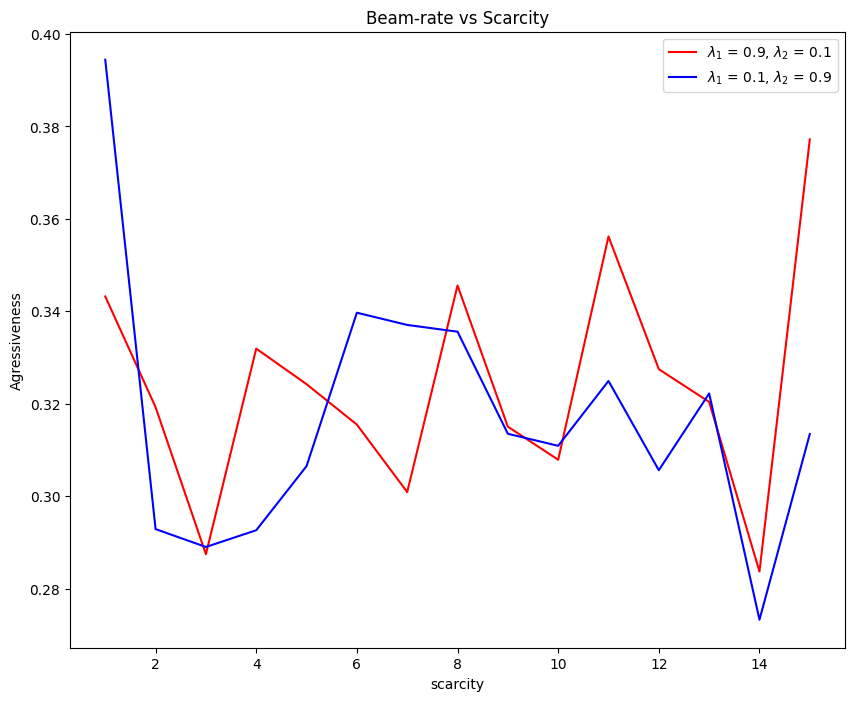

In [18]:
plot_experiment(rates, l1=0.9,l2=0.1, l1_2=0.1,l2_2=0.9)

In [23]:
def plot_food(foods, l1=1.0, l2=1.0, discount=0.995, x_dim=5, y_dim=5):
  plt.figure(figsize=(10, 8))

  plt.plot(Napples, foods[0], color='red', label=f'apples by player1')
  plt.plot(Napples, foods[1], color='blue', label=f'apples by player2')


  plt.title(f'apples collected vs Scarcity: $\lambda_1$ = {l1}, $\lambda_2$ = {l2}')
  plt.xlabel('scarcity')
  plt.ylabel('Apples collected')
  plt.legend()

  plt.savefig(f'/content/gdrive/MyDrive/ift6164/png/collected2{exp_id}.png')

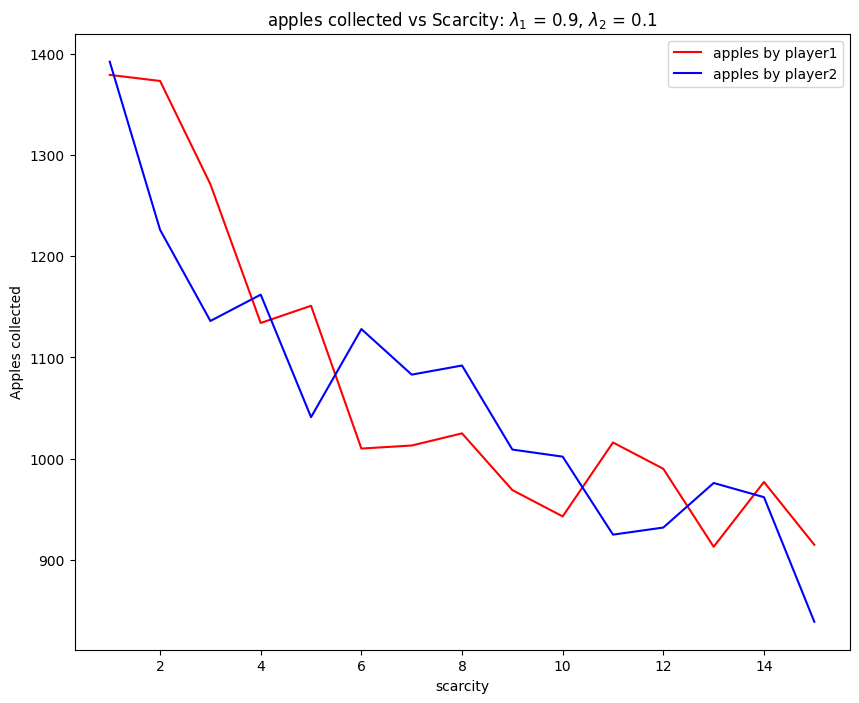

In [22]:
plot_food(foods1, l1=0.9,l2=0.1)

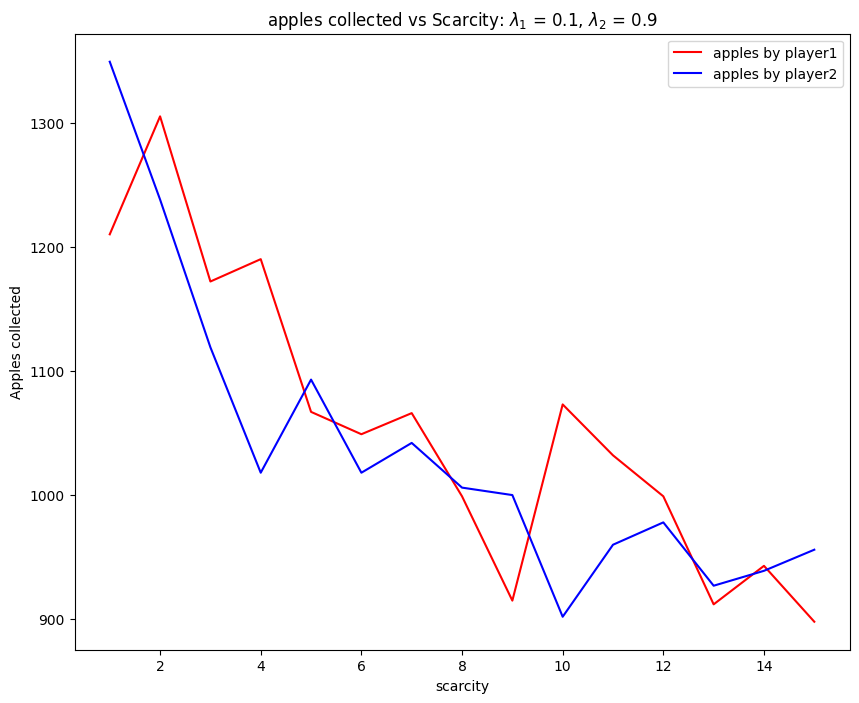

In [24]:
plot_food(foods2, l1=0.1,l2=0.9)

In [ ]:
num_runs = 10
Napples = [i for i in range(1, 16)]

foods_tot = [[],[]]
beam_rates = []

std_foods = [[],[]]
std_rates = []

N_tagged = 2
apples = 15
x_dim = 5
y_dim = 5
l1=0.9
l2=0.3
lr=0.00001


for i , N_apple in enumerate(Napples):
  run_rates = []
  run_foods = [[],[]]

  for run in range(num_runs):
    seed = run + 10*i  # we could take the system time
    seed_everything(seed)
    env = GatheringEnv.GatheringEnv(grid_size=(x_dim, y_dim), apples=apples, N_apple=N_apple, N_tagged=N_tagged)
    agent1 = Agent.Agent(input_dim=x_dim*y_dim, lr=lr, l1=l1, l2=l2)
    agent2 = Agent.Agent(input_dim=x_dim*y_dim, lr=lr, l1=l1, l2=l2)
    beam_rate, rewards = train_double_agents(env,agent1,agent2, 20, 100, 0.99)

    run_rates.append(beam_rate)
    run_foods[0].append(rewards[0])
    run_foods[1].append(rewards[1])

    print(f"run {run}, seed {seed}, mean reward: {rewards[0]},{rewards[1]}, mean beam rate: {beam_rate}")

  std_rates.append(np.std(run_rates))
  std_foods[0].append(np.std(run_foods[0]))
  std_foods[1].append(np.std(run_foods[1]))

  beam_rates.append(np.mean(run_rates))
  foods_tot[0].append(np.mean(run_foods[0]))
  foods_tot[1].append(np.mean(run_foods[1]))

In [26]:
save_logs(beam_rates, "/content/gdrive/MyDrive/ift6164/log", str(exp_id), f'p-{l1}-{l2}')

In [27]:
save_logs(foods_tot[0], "/content/gdrive/MyDrive/ift6164/log", str(exp_id), f'p-{l1}-{l2}-food1')

In [28]:
save_logs(foods_tot[1], "/content/gdrive/MyDrive/ift6164/log", str(exp_id), f'p-{l1}-{l2}-food2')

In [29]:
save_logs(std_foods[0], "/content/gdrive/MyDrive/ift6164/log", str(exp_id), f'p-{l1}-{l2}-stdfood1')

In [30]:
save_logs(std_foods[1], "/content/gdrive/MyDrive/ift6164/log", str(exp_id), f'p-{l1}-{l2}-stdfood2')

In [32]:
def plot_experiment_err(rates, std, l1=0.9, l2=0.9):
  plt.figure(figsize=(10, 8))

  plt.errorbar(Napples, rates, yerr=std, capsize=5)

  plt.title(f'Beam-rate vs scarcity for $\lambda_1$ = {l1}, $\lambda_2$ = {l2}')
  plt.xlabel('runs')
  plt.ylabel('Agressiveness')
  plt.legend()

  plt.savefig(f'/content/gdrive/MyDrive/ift6164/png/error_rates{exp_id}.png')

In [33]:
def plot_food_err(foods, std, l1=0.9, l2=0.9):
  plt.figure(figsize=(10, 8))

  print(len(Napples), len(foods[0]), len(std[0]))
  plt.errorbar(Napples, foods[0], yerr=std[0], label='Player 1', capsize=5)
  plt.errorbar(Napples, foods[1], yerr=std[1], label='Player 2', capsize=5)

  plt.title(f'apples collected vs Scarcity: $\lambda_1$ = {l1}, $\lambda_2$ = {l2}')
  plt.xlabel('scarcity')
  plt.ylabel('Apples collected')
  plt.legend()

  plt.savefig(f'/content/gdrive/MyDrive/ift6164/png/err_collected{exp_id}.png')

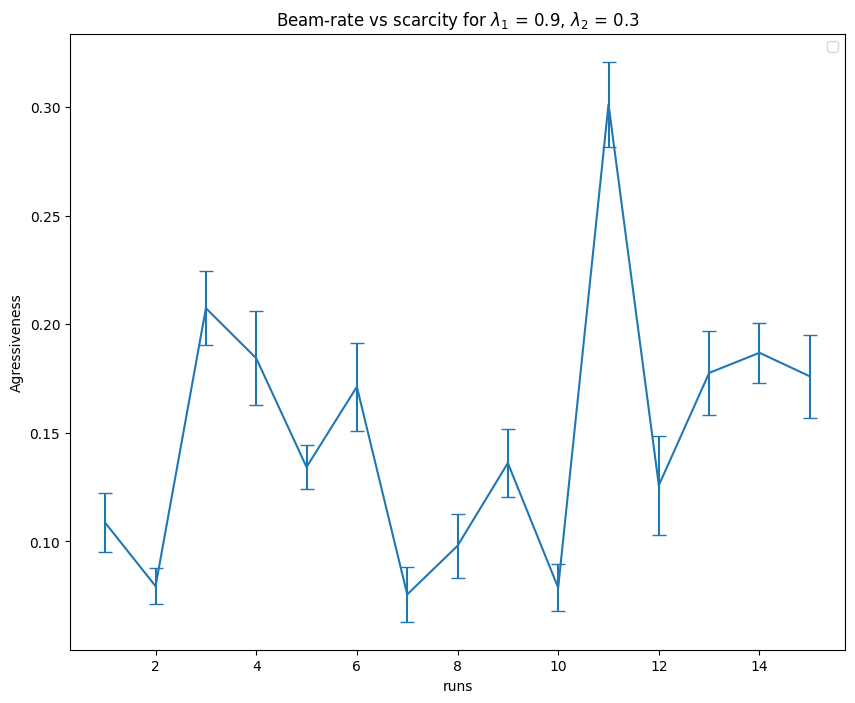

In [57]:
plot_experiment_err(beam_rates,std_rates,l1=0.9, l2=0.3)

15 15 15


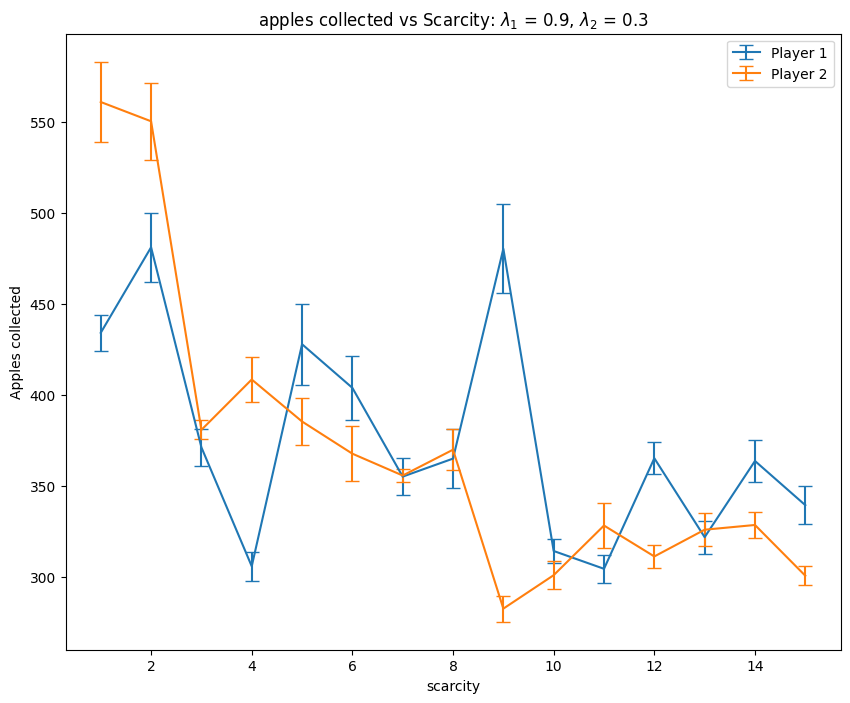

In [66]:
plot_food_err(foods_tot,std_foods,l1=0.9, l2=0.3)